# A linear regression model for price recommendation
We construct a machine learning model based on linear regression to recommend a price for an Airbnb property in Mallorca. The prediction is based on:<br />
    - Zipcode <br />
    - Property type<br />
    - Number of rooms<br />
    - Number of guests<br />

In [2]:
import plotly
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
%matplotlib inline

listings = pd.read_csv('listings.csv')

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (43,61,62) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Data Preparation

In [3]:
# numerize price
listings.price.dtypes
price_in_num = []
for i in range(listings.shape[0]):
    price_in_num.append(int(listings.price[i][1:-3].replace(',','')))
listings.price = np.asarray(price_in_num)

In [4]:
# numerize cleaninge fee
cleaning_fee_in_num = []
for i in range(listings.shape[0]):
    if listings.cleaning_fee.isna()[i]:
        cleaning_fee_in_num.append(np.nan)
    else:
        cleaning_fee_in_num.append(int(listings.cleaning_fee[i][1:-3].replace(',','')))
listings.cleaning_fee = np.asarray(cleaning_fee_in_num)

In [5]:
# numerize zipcode
zipcode_in_num = []
for i in range(listings.shape[0]):
    if str(listings.zipcode[i]).find('7')<0:
        zipcode_in_num.append(np.nan)
    else:
        zipcode_str = str(listings.zipcode[i])
        zipcode_in_num.append(int(zipcode_str[zipcode_str.find('7'):(zipcode_str.find('7')+4)]))
listings.zipcode = np.asarray(zipcode_in_num)

In [6]:
# looking for features that is correlated to price
listings.corr().price[abs(listings.corr().price)>0.05]

longitude               -0.070968
accommodates             0.346583
bathrooms                0.408298
bedrooms                 0.343615
beds                     0.259140
price                    1.000000
cleaning_fee             0.150330
guests_included          0.129852
number_of_reviews       -0.114778
number_of_reviews_ltm   -0.129768
review_scores_rating     0.059870
reviews_per_month       -0.178631
Name: price, dtype: float64

### Build feature matrix

In [7]:
# select features to build the model
features_included = ['zipcode','room_type','accommodates','bedrooms','bathrooms','beds','price']
df = listings[features_included]
df.isnull().sum(0)

zipcode         392
room_type         0
accommodates      0
bedrooms         12
bathrooms         5
beds             92
price             0
dtype: int64

In [8]:
listings.corr().bedrooms.sort_values(ascending=False)[:5]
listings.corr().beds.sort_values(ascending=False)[:5]
listings.corr().bathrooms.sort_values(ascending=False)[:5]

bathrooms       1.000000
bedrooms        0.811842
accommodates    0.787599
beds            0.699212
price           0.408298
Name: bathrooms, dtype: float64

### Impute missing values

In [9]:
# impute missing values with linear regression based on 
def impute_missing_values(df,feature = 'beds',reference = 'accommodates'):
    df_wo_missing_values = df.dropna(axis=0, how='any')
    X = np.asarray(df_wo_missing_values[reference]).reshape(-1,1)
    y = np.asarray(df_wo_missing_values[feature])
    reg = LinearRegression().fit(X,y)
    sel = df[feature][df[feature].isna()].index
    new_feature = np.asarray(df[feature])
    new_feature[sel]= reg.coef_*np.asarray(df[reference])[sel]+reg.intercept_
    df_new = df.drop(columns=[feature])
    df_new[feature]=new_feature
    return df_new

df = impute_missing_values(df,feature = 'beds',reference = 'accommodates')
df = impute_missing_values(df,feature = 'bathrooms',reference = 'accommodates')
df = impute_missing_values(df,feature = 'bedrooms',reference = 'accommodates')
df['zipcode_fill'] = df['zipcode'].fillna(df['zipcode'].mean())
df.isna().sum()

zipcode         392
room_type         0
accommodates      0
price             0
beds              0
bathrooms         0
bedrooms          0
zipcode_fill      0
dtype: int64

### Convert categorical features by one hot encoding

In [10]:
# conver categorical data 'room_type' to numerical data with one hot encoder
room_type_encoded = pd.get_dummies(df.room_type)
df_en = pd.concat([df.drop(columns=['room_type']), room_type_encoded], axis=1)
# remove outliers, aka luxury properties
df_sel = df_en[df_en.price<=2000]

In [11]:
# prepare data for linear regression to predict
X = np.asarray(df_sel.drop(columns=['price','zipcode']))
# X_norm = preprocessing.StandardScaler().fit(X).transform(X)
y = np.asarray(df_sel.price).reshape(-1,1)


# split dataset for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

# generate a model based on linear regression
lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit

# predict using the model
y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)

#Score using your model
test_score = r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)

print(test_score,train_score)

0.35378793075620485 0.34394247386429855


## Further reference on pricing based on neighborhoods and room_type
Since the price of Airbnb properties vary a lot and our model only explains ~35% of the variance, below are some further reference information to set a price for a new Airbnb propterty.

(0, 600)

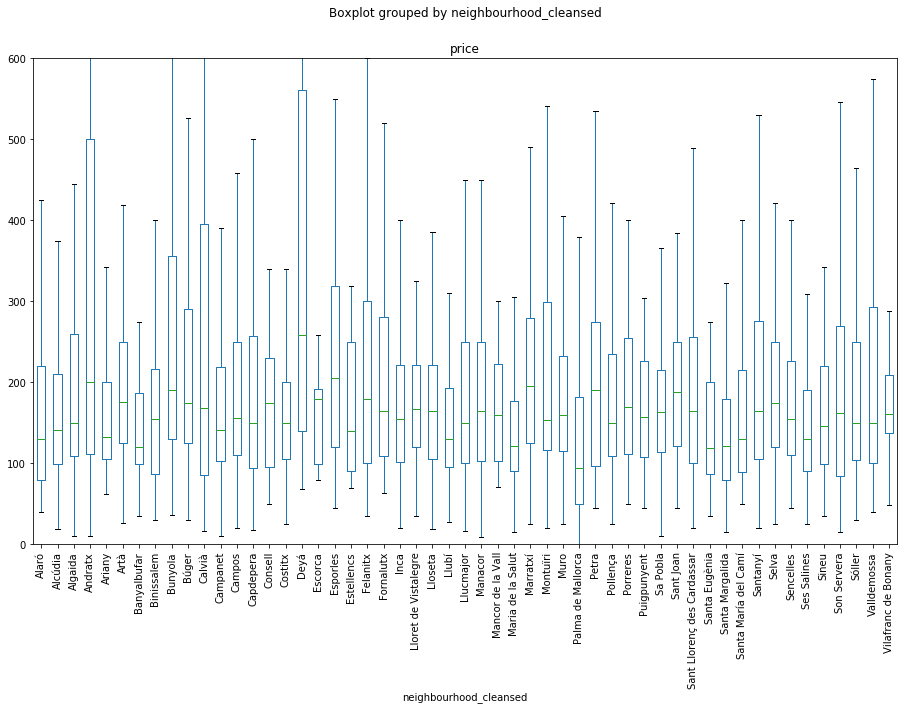

In [12]:
# visualize price distributin in different neighborhoods
listings.boxplot(column=['price'],by='neighbourhood_cleansed',grid=False, rot=90,figsize=(15,9),
                 showfliers=False)
plt.ylim([0,600])

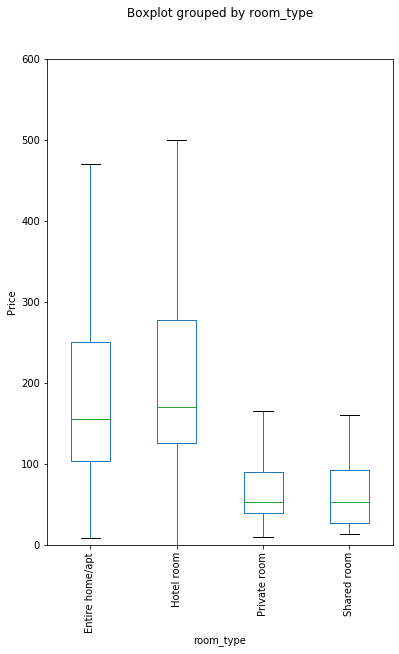

In [16]:
# visualize price distributin for different room types
listings.boxplot(column=['price'],by='room_type',grid=False, rot=90,figsize=(6,9), showfliers=False)
plt.ylim([0,600])
plt.ylabel('Price')
plt.title('')
plt.savefig('Price_by_room_type.png')